# Predicting diamonds price
The goal of this project is to predict the price of different diamonds through machine learning models. 

In order to achieve it, firstly, we will do a data exploratory analysis and, secondly, we will try different machine learning models to check which one gives the best prediction.

The error metric that we will use is RMSE. 

# About diamonds

The price of diamonds is determinate for the 4C's: Carat, Color, Cut and Clarity.

![image](https://i.pinimg.com/564x/10/ad/8e/10ad8ef96ead61b0f36b5b429e1f942b.jpg)

In our data set we will finde the next features:
* **id:** only for test & sample submission files, id for prediction sample identification
* **price**: price in USD
* **carat**: weight of the diamond
* **cut**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* **color**: diamond colour, from J (worst) to D (best)
* **clarity**: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* **x**: length in mm
* **y**: width in mm
* **z**: depth in mm
* **depth**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
* **table**: width of top of diamond relative to widest point (43--95)

# 1. Importing Data

In [1]:
# imports

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# data visualization

import matplotlib.pyplot as plt
import seaborn as sns

# machine learning models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# error metrics

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# pipeline

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
# for training our machine model and testing the results
train = pd.read_csv('../input/dapt202011mad/diamonds_train.csv')

In [3]:
# to make our final price prediction
test = pd.read_csv('../input/dapt202011mad/diamonds_test.csv')

# 2. Exploratory Data Analysis

### 2.1. Overview of the data sets

In [4]:
train.shape, test.shape

((40455, 10), (13485, 10))

In [5]:
train.describe().round(2)

,carat,depth,table,price,x,y,z
count,40455.00,40455.00,40455.00,40455.00,40455.00,40455.00,40455.00
mean,0.80,61.75,57.45,3928.44,5.73,5.73,3.54
std,0.48,1.43,2.23,3992.42,1.12,1.15,0.70
min,0.20,43.00,43.00,326.00,0.00,0.00,0.00
25%,0.40,61.00,56.00,945.00,4.71,4.72,2.91
50%,0.70,61.80,57.00,2397.00,5.69,5.71,3.52
75%,1.04,62.50,59.00,5331.00,6.54,6.54,4.04
max,4.50,79.00,95.00,18823.00,10.23,58.90,8.06


In [6]:
test.describe().round(2)

,id,carat,depth,table,x,y,z
count,13485.00,13485.00,13485.00,13485.00,13485.00,13485.00,13485.00
mean,6742.00,0.80,61.74,57.49,5.74,5.74,3.54
std,3892.93,0.47,1.44,2.24,1.11,1.13,0.73
min,0.00,0.20,50.80,51.00,0.00,0.00,0.00
25%,3371.00,0.40,61.00,56.00,4.73,4.73,2.92
50%,6742.00,0.70,61.90,57.00,5.70,5.72,3.53
75%,10113.00,1.04,62.50,59.00,6.53,6.53,4.04
max,13484.00,5.01,79.00,73.00,10.74,31.80,31.80


### 2.2. Data visualization

First of all, we are going to see how our data are distributed using a box plot. In all columns there are some outliers that we will have in mind during the data process for our machine learning models.

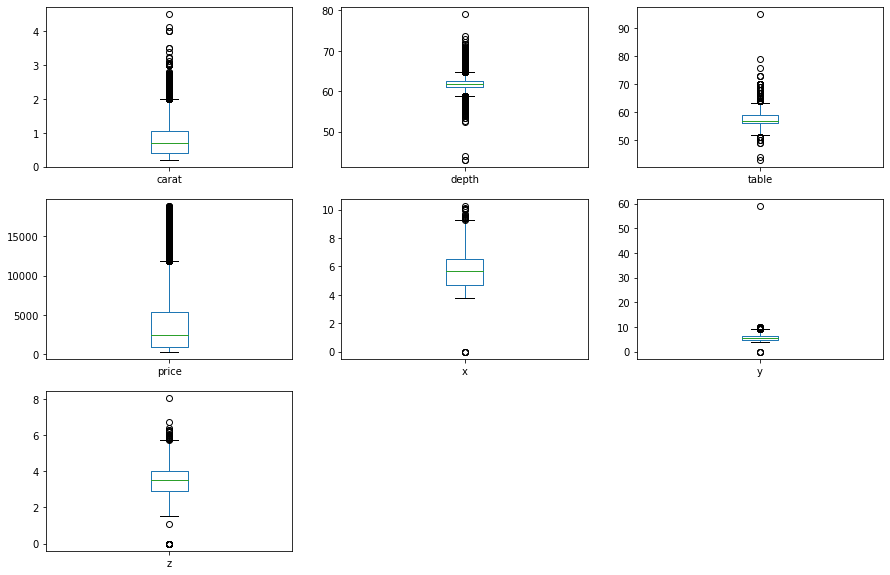

In [7]:
# train distribution

train.plot(kind='box', figsize=(15,10), subplots=True, layout=(3,3))
plt.show()

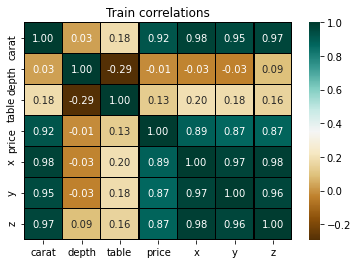

In [8]:
# train correlations

f,ax = plt.subplots(figsize=(6, 4))
sns.heatmap(train.corr(), annot=True,annot_kws = {"size": 10},linecolor = "black", linewidths=0.5, fmt = '.2f', ax=ax,cmap = "BrBG")
plt.title("Train correlations")
plt.show()

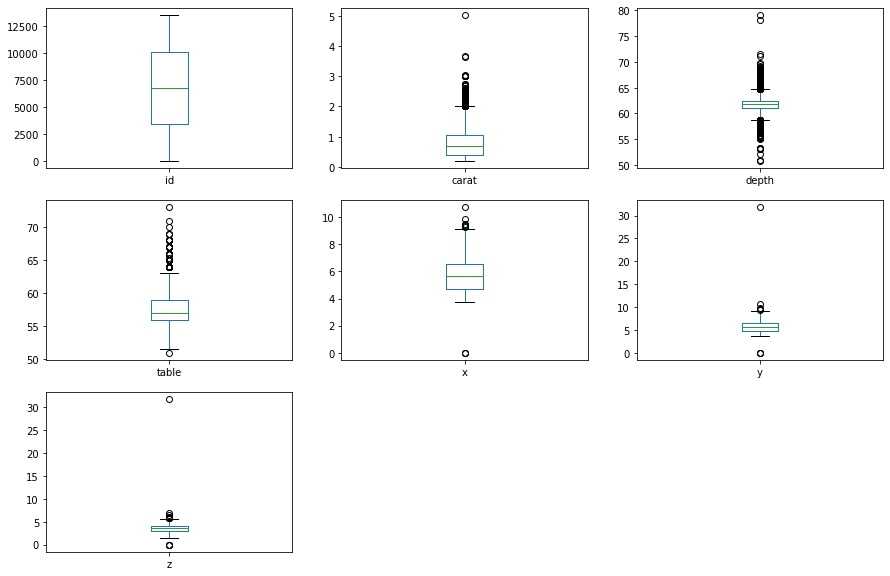

In [9]:
# test distribution 

test.plot(kind='box', figsize=(15,10), subplots=True, layout=(3,3))
plt.show()

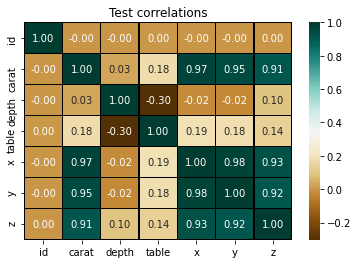

In [10]:
# test correlations

f,ax = plt.subplots(figsize=(6, 4))
sns.heatmap(test.corr(), annot=True,annot_kws = {"size": 10},linecolor = "black", linewidths=0.5, fmt = '.2f', ax=ax,cmap = "BrBG")
plt.title("Test correlations")
plt.show()

### 2.3. Conclusions

* Price is correlated with z,y,x and carat. But table and dept not much.

# 3. Transforming the data

## 3.1 Encoding

We are going to transform the category columns into category type in order to be able to transform it to machine learning understandability.

In [11]:
target = 'price'
cat_features = ['cut', 'color', 'clarity']
num_features = ['carat', 'depth', 'table', 'x', 'y', 'z']

for cat_feat in cat_features:
    train[cat_feat] = train[cat_feat].astype('category')
    test[cat_feat] = test[cat_feat].astype('category')
    
cat_df = pd.get_dummies(train[cat_features])
num_df = train.loc[:,num_features]
train_df = pd.concat([cat_df, num_df], axis=1)

cat_df = pd.get_dummies(test[cat_features])
num_df = test.loc[:,num_features]
test_df = pd.concat([cat_df, num_df], axis=1)


features = list(cat_df.columns) + list(num_df.columns)

## 3.2. Scaling

Then, we are going to scale the columns and creating the X and y dataframes. We use Standard Scaler because out data have some outliers and in this way, they won't affect our machine learning model too much.

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scaling train_df
X = scaler.fit_transform(train_df.loc[:,features].values)
y = train[target]

# 4. Modeling

In [13]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((30341, 26), (10114, 26), (30341,), (10114,))

In [15]:
from sklearn.ensemble import ExtraTreesRegressor
extratr = ExtraTreesRegressor(bootstrap=False, max_features=0.8, min_samples_leaf=1, min_samples_split=16, n_estimators=100)
model_extratr = extratr.fit(X_train, y_train)

predictions_train = model_extratr.predict(X_train)
y_pred_extratr = model_extratr.predict(X_test)
mean_squared_error(y_test, y_pred_extratr)**0.5

541.3426033152127

## 3.3. Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)

In [17]:
# RMSE Linear Regression

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_lr)**0.5

1128.0322070344253

## 3.4. Random Forest Regressor

In [18]:
rf = RandomForestRegressor()
model_rf = rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# RMSE Random Forest

mean_squared_error(y_test, y_pred_rf)**0.5

564.7138424059965

In [19]:
# RMSE Random Forest

mean_squared_error(y_test, y_pred_rf)**0.5

564.7138424059965

In [20]:
# testing Gridsearch with random forest regressor

"""
ptmodel = RandomForestRegressor()
ptparams = ({'n_estimators': np.arange(500,1000), 'n_jobs': np.arange(1,10) , 'max_depth': np.arange(1,10)})
gridsearch = GridSearchCV(ptmodel,ptparams)
gridsearch.fit(X_train,y_train)
gridsearch.best_params_

Output:
n_jobs=7, n_estimators=1000
"""

"\nptmodel = RandomForestRegressor()\nptparams = ({'n_estimators': np.arange(500,1000), 'n_jobs': np.arange(1,10) , 'max_depth': np.arange(1,10)})\ngridsearch = GridSearchCV(ptmodel,ptparams)\ngridsearch.fit(X_train,y_train)\ngridsearch.best_params_\n\nOutput:\nn_jobs=7, n_estimators=1000\n"

In [21]:
rf = RandomForestRegressor(n_jobs=7, n_estimators=1000)
model_rf = rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# RMSE Random Forest

mean_squared_error(y_test, y_pred_rf)**0.5

561.5937848225822

## 3.6. KNeighbors Regressor

In [22]:
# KNeighbors model 

clf_knn = KNeighborsRegressor()
model_knn = clf_knn.fit(X_train , y_train)
y_pred_knn = clf_knn.predict(X_test)

In [23]:
# RMSE KNeighbors (It's greater than Random Forest so maybe is not the best model)

mean_squared_error(y_test, y_pred_knn)**0.5

943.6132657427737

In [24]:
# Optimizing model using Grid Search

"""
ptmodel = KNeighborsRegressor()
ptrange = np.arange(1,11)
ptparams = ({'n_neighbors': ptrange})
gridsearch = GridSearchCV(ptmodel,ptparams,cv=10)

gridsearch.fit(X_train,y_train)
gridsearch.best_params_
gridsearch.best_score_

Output:
n_neighbors=3

"""

"\nptmodel = KNeighborsRegressor()\nptrange = np.arange(1,11)\nptparams = ({'n_neighbors': ptrange})\ngridsearch = GridSearchCV(ptmodel,ptparams,cv=10)\n\ngridsearch.fit(X_train,y_train)\ngridsearch.best_params_\ngridsearch.best_score_\n\nOutput:\nn_neighbors=3\n\n"

In [25]:
# making the model again with the best param, n_neghbors=3
clf_knn = KNeighborsRegressor(n_neighbors=3)
model_knn = clf_knn.fit(X_train , y_train)
y_pred_knn = clf_knn.predict(X_test)
mean_squared_error(y_test, y_pred_knn)**0.5

930.4377690423526

# 4.6. Decision Trees

### 4.6.1. Gradient Boosting

In [26]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [27]:
# gradient boosting

reg = GradientBoostingRegressor(**params)
model_gb = reg.fit(X_train, y_train)
y_pred_gb = reg.predict(X_test)
mean_squared_error(y_test, y_pred_gb)**0.5

749.0263280245646

In [28]:
# looking the best parameters of Gradient Boosting with Grid Search

"""
ptmodel = GradientBoostingRegressor()
#ptrange = np.arange(1,1000)
ptparams = ({'n_estimators': np.arange(1,1000), 'max_depth': np.arange(1,10)})
gridsearch = GridSearchCV(ptmodel,ptparams,cv=10)
gridsearch.fit(X_train,y_train)
gridsearch.best_params_

Output:
"""

"\nptmodel = GradientBoostingRegressor()\n#ptrange = np.arange(1,1000)\nptparams = ({'n_estimators': np.arange(1,1000), 'max_depth': np.arange(1,10)})\ngridsearch = GridSearchCV(ptmodel,ptparams,cv=10)\ngridsearch.fit(X_train,y_train)\ngridsearch.best_params_\n\nOutput:\n"

### 4.6.2. XGBRegressor

In [29]:
# XGBRegressor : best result by now

from xgboost import XGBRegressor

xgbr = XGBRegressor(verbosity=0) 
model_xgbr = xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)
mean_squared_error(y_test, y_pred_xgbr)**0.5

558.8851276889533

In [30]:
# looking the best parameters of XGBRegressor with Grid Search

""""
ptmodel = XGBRegressor()
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
gridsearch = GridSearchCV(ptmodel,params)
gridsearch.fit(X_train,y_train)
gridsearch.best_params_

Output:
{'colsample_bytree': 0.9,
 'gamma': 0.3,
 'max_depth': 4,
 'min_child_weight': 4,
 'subsample': 1.0}
 """

'"\nptmodel = XGBRegressor()\nparams = {\'min_child_weight\':[4,5], \'gamma\':[i/10.0 for i in range(3,6)],  \'subsample\':[i/10.0 for i in range(6,11)],\n\'colsample_bytree\':[i/10.0 for i in range(6,11)], \'max_depth\': [2,3,4]}\ngridsearch = GridSearchCV(ptmodel,params)\ngridsearch.fit(X_train,y_train)\ngridsearch.best_params_\n\nOutput:\n{\'colsample_bytree\': 0.9,\n \'gamma\': 0.3,\n \'max_depth\': 4,\n \'min_child_weight\': 4,\n \'subsample\': 1.0}\n '

In [31]:
# doing again the XGBRegressor model with the best hyperparameters, but changing max_depth
xgbr = XGBRegressor(verbosity=0, colsample_bytree=0.9, gamma=0.3, max_depth=8, min_child_weight=4, subsample=1.0) 
model_xgbr = xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)
mean_squared_error(y_test, y_pred_xgbr)**0.5

552.9287219780743

### 4.6.3. LGBMRegressor

In [32]:
# LGMB

from lightgbm import LGBMRegressor

lgmb = LGBMRegressor()
model_lgmb = lgmb.fit(X_train, y_train)
y_pred_lgmb = lgmb.predict(X_test)
mean_squared_error(y_test, y_pred_lgmb)**0.5

556.4760082520434

In [33]:
# looking fot the best parameters using Grid Search.

""""

ptmodel = LGBMRegressor()
params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [2, 3, 4, 6, 8, 10],
    'n_estimators': [50, 100, 200, 500],
}

gridsearch = GridSearchCV(ptmodel,params)
gridsearch.fit(X_train,y_train)
gridsearch.best_params_

Output:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'num_leaves': 21}
"""

'"\n\nptmodel = LGBMRegressor()\nparams = {\n    \'num_leaves\': [7, 14, 21, 28, 31, 50],\n    \'learning_rate\': [0.1, 0.03, 0.003],\n    \'max_depth\': [2, 3, 4, 6, 8, 10],\n    \'n_estimators\': [50, 100, 200, 500],\n}\n\ngridsearch = GridSearchCV(ptmodel,params)\ngridsearch.fit(X_train,y_train)\ngridsearch.best_params_\n\nOutput:\n{\'learning_rate\': 0.1, \'max_depth\': 4, \'n_estimators\': 500, \'num_leaves\': 21}\n'

In [34]:
# LGMB again with parameters ajusted

from lightgbm import LGBMRegressor

lgmb = LGBMRegressor(learning_rate=0.1, max_depth=8, n_estimators=400, num_leaves=21)
model_lgmb = lgmb.fit(X_train, y_train)
y_pred_lgmb = model_lgmb.predict(X_test)
mean_squared_error(y_test, y_pred_lgmb)**0.5

550.2879515484341

In [35]:
# ADABoost Regressor: result very high.

from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(n_estimators=100)
model_ada = ada.fit(X_train, y_train)
y_pred_ada = model_ada.predict(X_test)
mean_squared_error(y_test, y_pred_ada)**0.5

1587.9286375121553

# 5. Pipeline

In [36]:
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                       ('scaler', StandardScaler())])

In [37]:
numerical_transformer.fit_transform(train[num_features])

array([[ 0.8670056 ,  0.45201864,  0.24798091,  0.97880679,  0.92198533,
         1.02265738],
       [-1.00455749,  0.8710986 , -0.19974534, -1.22673789, -1.17981558,
        -1.1292594 ],
       [-0.18443434,  2.61726508, -1.09519783, -0.09728557, -0.17688154,
         0.16189067],
       ...,
       [ 0.44642962,  0.66155862, -0.64747158,  0.56971383,  0.5993022 ,
         0.6783507 ],
       [-0.98352869,  0.10278535, -1.4086062 , -1.13780463, -1.10132509,
        -1.11491329],
       [ 0.93009199,  0.172632  ,  0.24798091,  0.97880679,  1.00047582,
         1.02265738]])

In [38]:
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [39]:
categorical_transformer.fit_transform(train[cat_features])

<40455x20 sparse matrix of type '<class 'numpy.float64'>'
	with 121365 stored elements in Compressed Sparse Row format>

In [40]:
preprocessor = ColumnTransformer(transformers=[('numerical_preprocessor', numerical_transformer, num_features),
                                                ('categorical_preprocessor', categorical_transformer, cat_features)])

In [41]:
# appliying preprocessor to all the tran data set
features_pipeline = cat_features + num_features

preprocessor.fit_transform(train[features_pipeline])

array([[ 0.8670056 ,  0.45201864,  0.24798091, ...,  1.        ,
         0.        ,  0.        ],
       [-1.00455749,  0.8710986 , -0.19974534, ...,  1.        ,
         0.        ,  0.        ],
       [-0.18443434,  2.61726508, -1.09519783, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.44642962,  0.66155862, -0.64747158, ...,  0.        ,
         0.        ,  0.        ],
       [-0.98352869,  0.10278535, -1.4086062 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.93009199,  0.172632  ,  0.24798091, ...,  0.        ,
         0.        ,  0.        ]])

In [42]:
# creating pipeline

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('rf_regressor', RandomForestRegressor())]) 

In [43]:
X = train[features_pipeline]
y = train[target]

In [44]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30341, 9), (10114, 9), (30341,), (10114,))

In [45]:
# apllying my pipeline
model_rf = pipeline_rf.fit(X_train, y_train)

In [46]:
y_pred_pipeline_rf = model_rf.predict(X_test)

In [47]:
mean_squared_error(y_test, y_pred_pipeline_rf)**0.5

564.5795980958993

# 5. Submission

In [48]:
# scaling test_df
X_predict = scaler.transform(test_df.loc[:,features].values)

# testing our model vs X_predict
y_hat = model_lgmb.predict(X_predict)

In [49]:
# cross validation

errors = cross_val_score(model_lgmb, X, y, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [50]:
np.mean(-errors)

535.1988444339925

In [51]:
# exporting our results.
submission = pd.DataFrame({'id': test['id'], 'price': y_hat})
submission.to_csv('submission.csv', index=False)